In [1]:
import pandas as pd
import re
import string
from collections import Counter
import time
import numpy as np

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import nltk
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer

from textblob import TextBlob

from deep_translator import GoogleTranslator
from langdetect import detect

import warnings
warnings.filterwarnings('ignore')

In [2]:
matplotlib.rcParams['figure.figsize']=(12,6)

In [3]:
#Loading the data into data variable.
raw_data = pd.read_excel('Data Analyst - Test Data.xlsx')

raw_data.head()

,Review,date,Location
0,I was very impressed with the resort.\n Great ...,2019-08-20,Sebastian
1,The rooms were nice the outside needs work als...,2019-08-20,Los Angeles
2,Great location! I have stayed at this hotel on...,2019-08-20,Georgia
3,The hotel was adequate for my stay. The strips...,2019-08-20,NaN
4,"Great location, room was large and spacious. P...",2019-08-19,Palm Harbor


In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6448 entries, 0 to 6447
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Review    6393 non-null   object        
 1   date      6448 non-null   datetime64[ns]
 2   Location  1711 non-null   object        
dtypes: datetime64[ns](1), object(2)
memory usage: 151.2+ KB


We can see that there are some missing values in `Review` and `Location` column.

Lets check the no of missing values in each column and try to remove them.

In [5]:
raw_data.isna().sum()

Review        55
date           0
Location    4737
dtype: int64

As the number of missing values is too high (almost 70% missing) in location column we will have to ignore that column alltogether.

In [6]:
raw_data.dropna(axis=0, subset=['Review'], inplace=True)
raw_data.drop('Location',axis=1, inplace=True)

#dropping the row which had only emojis on it. 
raw_data.drop(index=[507], axis=0 , inplace=True)

When we look into the data we see that the reviews are from many parts of the world so it is possible that they are written in many languages.

So we first need to translate all the reviews in english to simplify our approach

In [7]:
data = raw_data.copy()

In [8]:
def translation(data):
    translator = GoogleTranslator()
    translated_column = []
    
    for reviews in data:
        if (detect(reviews)!='en'):
            translated_text = translator.translate(reviews)
            translated_column.append(translated_text)
        else:
            translated_column.append(reviews)
    return translated_column

In [9]:
traslated_text = translation(data['Review'])

In [10]:
data['Review'] = translated_text

In [11]:
data.to_excel('Data Analyst - Test Data Translated.xlsx')

In [12]:
data = pd.read_excel('Data Analyst - Test Data Translated.xlsx')
data.drop('Unnamed: 0', axis=1, inplace=True)

In [13]:
# emoji_pattern = re.compile("["
#         u"\U0001F600-\U0001F64F"  # emoticons
#         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
#         u"\U0001F680-\U0001F6FF"  # transport & map symbols
#         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
#                            "]+", flags=re.UNICODE)
# print(emoji_pattern.sub(r'', data['Review'][505])) # no emoji

We can see there are lots of unwanted `Read more` and `Read less` occuring in the Reviews so lets try to clean them. 

In [14]:
#creating a regrex code for eleminating the words.
pat = 'Read more|Read less'

new_review = []
for review in data['Review']:
    new = re.sub(pat,'',review)
    new_review.append(new)

data['cleaned_review'] = new_review

Lets see which are the words which have appeared most no of times.

Text(0.5, 1.0, 'Most Common Words')

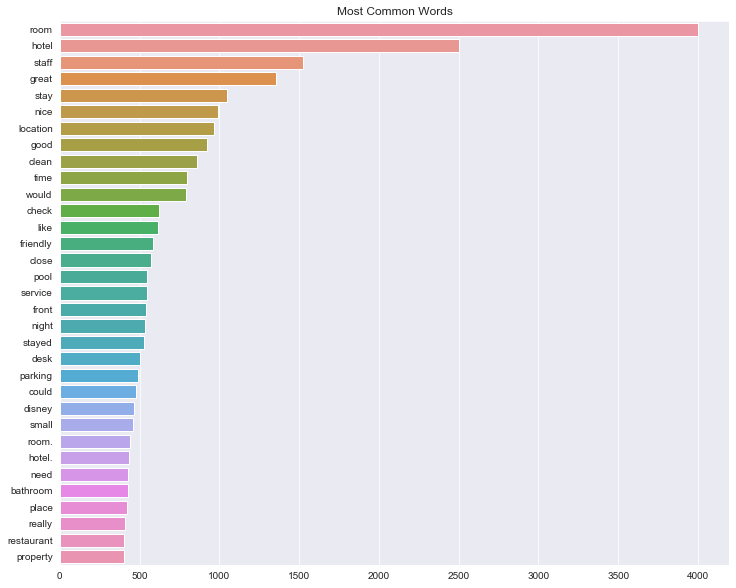

In [15]:
#making list of all the words and storing it in corpus
corpus=[]
new= data['cleaned_review'].str.split()
new=new.values.tolist()
corpus=[word.lower() for i in new for word in i]

#storing stopwords in stop varible
stop = set(stopwords.words('english'))

# lemmatize text
corpus = [WordNetLemmatizer().lemmatize(w) for w in corpus if len(w)>3]
    

#making a dict of words and number of their occurance
counter = Counter(corpus)

#storing most number of words occured in most
most = counter.most_common()

#creating list of varibles which does not fall under stopwords. 
x, y = [], []
for word, count in most[:50]:
    if (word not in stop):
        x.append(word)
        y.append(count)

        
#visualing the words
plt.figure(figsize=(12,10));
sns.set_style('darkgrid')
sns.barplot(x=y, y=x);
# plt.savefig('Most common words.png')
plt.title('Most Common Words')

- Words like `room` `hotel` `staff` have appeared most times that may mean most of the reviews are about them.
- Also positive words like `great` `nice` `clean` suggest that most of the reviews are postive.
- Some words seems to be analysed more to know in which sentiment they are used in.

In [16]:
def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))
    
    corpus = []
    new= text.str.split()
    new=new.values.tolist()
    corpus1=[word for i in new for word in i]
    for word in corpus1:
        if (word not in stop):
            corpus.append(word)
        

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:20]

    top_n_bigrams=_get_top_ngram(text,n)[:20]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)
#     plt.savefig('Most common words3.png')

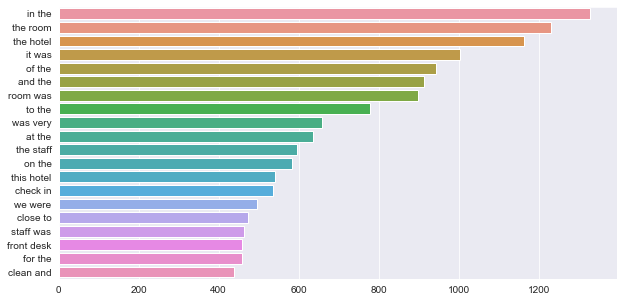

In [17]:
plt.figure(figsize=(10,5))
plot_top_ngrams_barchart(data['cleaned_review'],2)

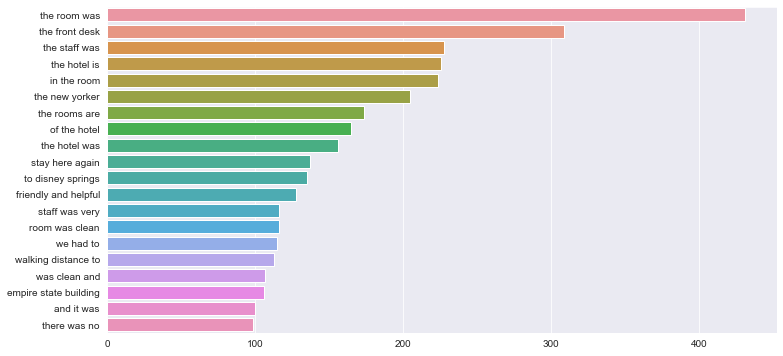

In [18]:

plot_top_ngrams_barchart(data['cleaned_review'],3)

In [19]:
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [20]:
def clean_text(text):
    #lower the text
    text = text.lower()
    
    #tokenise the text and remove the punctutaion
    words = nltk.word_tokenize(text)
    text=[word for word in words if word.isalpha()]
    
    #remove words that contain numbers
    text = [word for word in text if not any (c.isdigit() for c in word)]
    
    #remove the stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    
    # remove words with less than one letter
    text = [t for t in text if len(t) > 1]
    
    # pos tag text
    pos_tags = pos_tag(text)
    
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    
    #join all
    text = " ".join(text)
    return text

In [21]:
data['cleaned_review'] = data['cleaned_review'].apply(lambda x: clean_text(x))

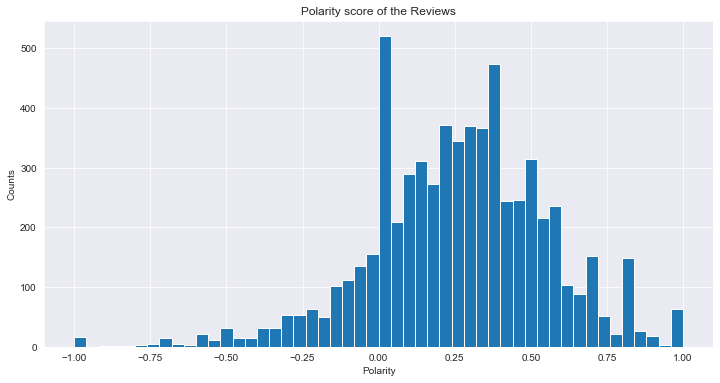

In [22]:
# Lets define a funtion to plot Polarity Histogram

def plot_polarity_hist(text):
    
    def _polarity(text):
        return TextBlob(text).sentiment.polarity
    
    polarity_score = text.apply(lambda x: _polarity(x))
    plt.hist(polarity_score, bins=50)
    plt.xlabel('Polarity')
    plt.ylabel('Counts')
    plt.title('Polarity score of the Reviews')
#     plt.savefig('Polarity score of the Reviews.png')
    return polarity_score

sentiments = plot_polarity_hist(data['cleaned_review'])

Lets create a word cloud.

In [23]:
data['sentiment'] = sentiments

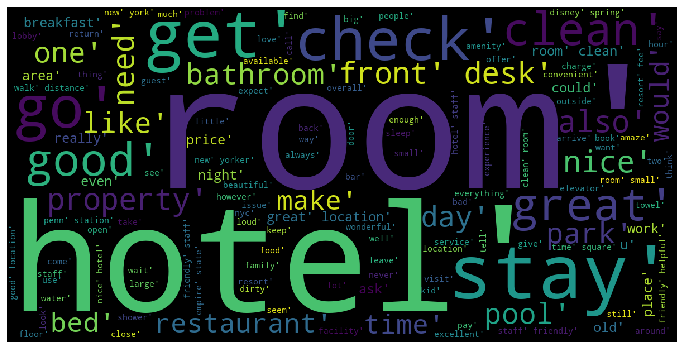

In [24]:
corpus1 = []
new1 = data['cleaned_review'].str.split()
new1 = new1.values.tolist()
corpus1 = [word.lower() for i in new1 for word in i]

from wordcloud import WordCloud, STOPWORDS

stopword = set(STOPWORDS)

def show_wordcloud(data, color):
    wordcloud = WordCloud(background_color=color,
                          stopwords=stopword,
#                           max_words=100,
#                           max_font_size=600,
#                           random_state=45,
                          scale=3
                         )
    wordcloud = wordcloud.generate(str(data))
    
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(corpus1,'black')

In [30]:
happy_sent = data[data.sentiment>0]
not_happy_sent = data[data.sentiment<0]
# neutral = data[data.sentiment==0]

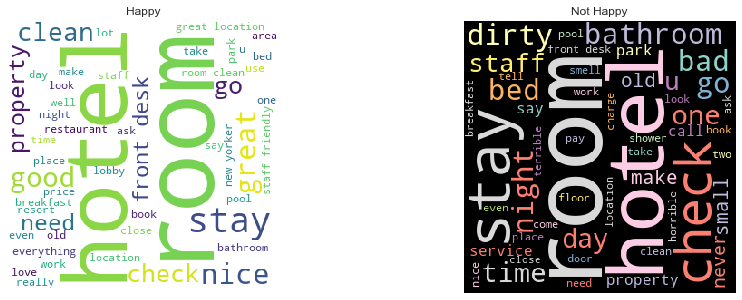

In [31]:
#creating two series for the wordcloud 
train_happy = pd.Series(happy_sent['cleaned_review'].tolist()).astype(str)
train_not_happy = pd.Series(not_happy_sent['cleaned_review'].tolist()).astype(str)
# train_neutral = pd.Series(netural['cleaned_review'].tolist()).astype(str)

cloud_happy = WordCloud(background_color="white",max_words=50,width=300, height=300,stopwords=STOPWORDS).generate(" ".join(train_happy.astype(str)))
cloud_not_happy = WordCloud(background_color="black",max_words=50,width=300, height=300,colormap='Set3',stopwords=STOPWORDS).generate(" ".join(train_not_happy.astype(str)))
# cloud_neutral = WordCloud(background_color="black",max_words=50,width=300, height=300,colormap='Set2',stopwords=STOPWORDS).generate(" ".join(train_neutral.astype(str)))

fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
ax = axes[0]
ax.imshow(cloud_happy)
ax.set_title("Happy")
ax.axis('off')

ax = axes[1]
ax.imshow(cloud_not_happy)
ax.set_title("Not Happy")
ax.axis('off')

# ax = axes[1]
# ax.imshow(cloud_neutral)
# ax.set_title("Neutral")
# ax.axis('off')

plt.show()

- We can notice that majority of the comments are on the positive side and lies between 0-0.5 polarity that means majority of the customers liked the hotels that they visited.
- Also, few customers gave highly postive reviews that could suggest that they must have rated it 5 stars.
- On the other hand, some customers did not enjoyed thier stay at hotel.

In [32]:
def sentiment_vader(text, sid):
    ss = sid.polarity_scores(text)
    ss.pop('compound')
    return max(ss, key=ss.get)

def sentiment_textblob(text):
        x = TextBlob(text).sentiment.polarity
        
        if x<0:
            return 'neg'
        elif x==0:
            return 'neu'
        else:
            return 'pos'

def plot_sentiment_barchart(text, method='TextBlob'):
    if method == 'TextBlob':
        sentiment = text.map(lambda x: sentiment_textblob(x))
    elif method == 'Vader':
        nltk.download('vader_lexicon')
        sid = SentimentIntensityAnalyzer()
        sentiment = text.map(lambda x: sentiment_vader(x, sid=sid))
    else:
        raise ValueError('Textblob or Vader')
    
    plt.bar(sentiment.value_counts().index,
            sentiment.value_counts(),color=['green', 'red', 'blue'])
#     plt.savefig('Total pos neg Reviews.png')

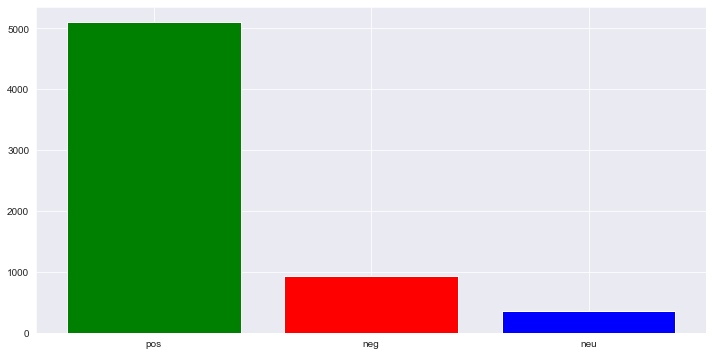

In [33]:
plot_sentiment_barchart(data['cleaned_review'], method='TextBlob')

- By this bar chart we can see how many of the reviews are postive (around 5000 which makes up around 80% of the reviews).
- Around 1000 review were negative which is only around 15% of the total reviews.
- And very few were netural about their stay around 5%.

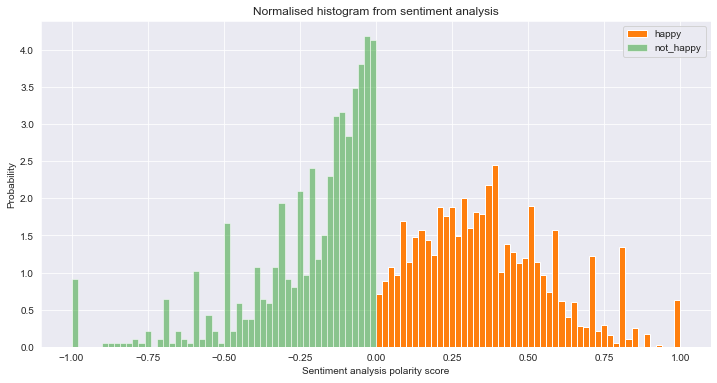

In [34]:
happy_sent = data[data.sentiment>0]
not_happy_sent = data[data['sentiment']<0]
# neutral = data[data['sentiment']==0]


pal = sns.color_palette()
plt.figure()

plt.hist(happy_sent['sentiment'], bins=100, range=[-1, 1], color=pal[1], normed=True, label='happy')
plt.hist(not_happy_sent['sentiment'], bins=100, range=[-1, 1], color=pal[2], normed=True, alpha=0.5, label='not_happy')
# plt.hist(neutral['sentiment'], bins=100, range=[-1, 1], color=pal[3], normed=True, alpha=0.3, label='neutral')

# plt.figure(figsize=(8,5))
plt.title('Normalised histogram from sentiment analysis')
plt.legend()
plt.xlabel('Sentiment analysis polarity score')
plt.ylabel('Probability')
plt.savefig('Sentiment analysis polarity score.png')